<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:68 px; height:68px;">
<img src="./images/nmc_logo.png" alt="NMC Logo" style="height: 68px;">
</div>
    
<h1 align="left">读取天气雷达数据</h1>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### 主要功能:
* **read_radar**模块提供`StandardData`类, 用于读取["天气雷达基数据标准格式(V1.0)"](https://wenku.baidu.com/view/07e7d51a842458fb770bf78a6529647d272834d6.html)
* **export_radar**模块提供`standard_data_to_pyart`函数, 将`StandardData`对象转化为[**pyart**](http://arm-doe.github.io/pyart/)雷达数据类
* **retrieve_micaps_server**模块提供
 * `get_radar_mosaic`读取雷达拼图数据
 * `get_radar_mosaics`读取多个雷达拼图数据
 * `get_swan_radar`读取SWAN的131雷达格式数据
 * `get_radar_standard`读取单站雷达标准格式基数据

In [36]:
# set up things
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# load libraries
import numpy as np
import xarray as xr
import pyart
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from nmc_met_io.read_radar import StandardData
from nmc_met_io.export_radar import standard_data_to_pyart
from nmc_met_io.retrieve_micaps_server import get_radar_mosaic, get_radar_mosaics, \
                                              get_swan_radar, get_radar_standard
from nmc_met_graphics.plot.china_map import add_china_map_2cartopy
from metpy.plots import colortables

xr.set_options(display_style="text")

## 读取单站雷达标准格式基数据

In [38]:
# read GuangZhou radar data.
data = StandardData('./samples/Z_RADR_I_Z9200_20200327114200_O_DOR_SAD_CAP_FMT.BIN.BZ2')
data

Radar station: GuangZhou/Z9200;
Scan time: 2020-03-27 03:42:00;
Longitude/Latitude: (113.355, 23.004);
Height: 179m;
Task name: VCP21D

In [39]:
# convert the standard data to pyart data
radar = standard_data_to_pyart(data)

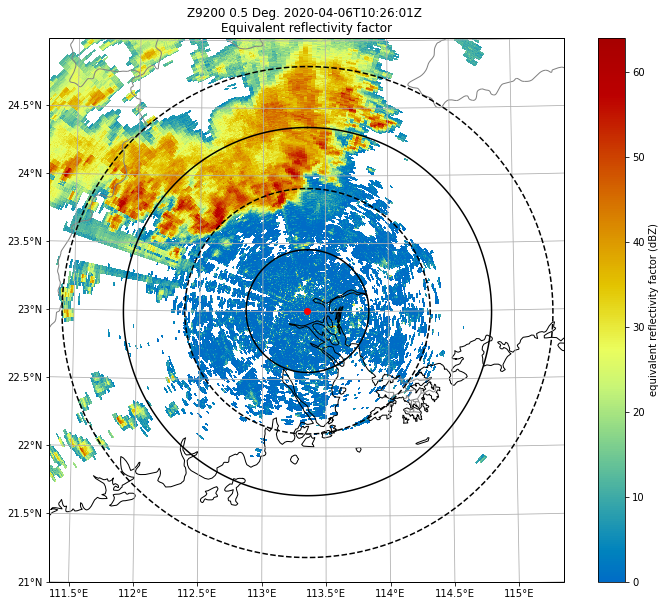

In [40]:
# create the displays and figure
display = pyart.graph.RadarMapDisplay(radar)

# Setting projection and ploting the second tilt
projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                   central_longitude=radar.longitude['data'][0])

fig = plt.figure(figsize=(12,10))
display.plot_ppi_map('reflectivity', 0, vmin=0, vmax=64,
                     min_lon=111.35, max_lon=115.35, min_lat=21, max_lat=25,
                     lon_lines=np.arange(111, 116, 0.5), resolution='10m',
                     lat_lines=np.arange(21, 26, 0.5), projection=projection,
                     fig=fig, lat_0=radar.latitude['data'][0],
                     lon_0=radar.longitude['data'][0])

# Plot range rings at 10, 20, 30, 40km
display.plot_range_ring(50., line_style='k-')
display.plot_range_ring(100., line_style='k--')
display.plot_range_ring(150., line_style='k-')
display.plot_range_ring(200., line_style='k--')

# Indicate the radar location with a point
display.plot_point(radar.longitude['data'][0], radar.latitude['data'][0])

plt.show()

### 可直接从MICAPS Cassandra服务器上读取单站雷达数据

In [41]:
data = get_radar_standard('SINGLERADAR/ARCHIVES/PRE_QC/广州/', filename="Z_RADR_I_Z9200_20200327215400_O_DOR_SAD_CAP_FMT.BIN.BZ2")
radar = standard_data_to_pyart(data)
data

Radar station: GuangZhou/Z9200;
Scan time: 2020-03-27 13:54:00;
Longitude/Latitude: (113.355, 23.004);
Height: 179m;
Task name: VCP21D

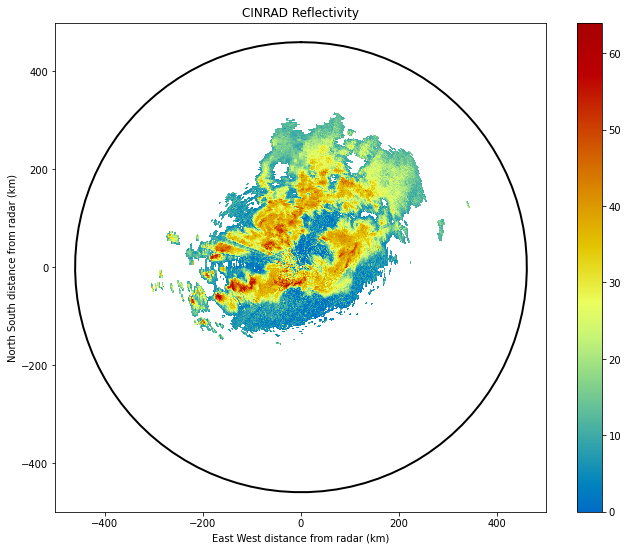

In [42]:
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(11, 9))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot('reflectivity', 0, title='CINRAD Reflectivity',
             vmin=0, vmax=64, colorbar_label='', ax=ax)
display.plot_range_ring(radar.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-500, 500), ylim=(-500, 500), ax=ax)
plt.show()

## 读取全国雷达拼图数据

In [43]:
# 从"RADARMOSAIC/CREF/"数据目录下读取最新时刻的雷达拼图数据
cref = get_radar_mosaic("RADARMOSAIC/CREF/")
cref

<xarray.Dataset>
Dimensions:  (lat: 4200, lon: 6200, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2020-03-28T15:00:00
  * lat      (lat) float64 12.21 12.22 12.23 12.24 ... 54.17 54.18 54.19 54.2
  * lon      (lon) float64 73.0 73.0 73.01 73.02 ... 135.0 135.0 135.0 135.0
Data variables:
    data     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra Server

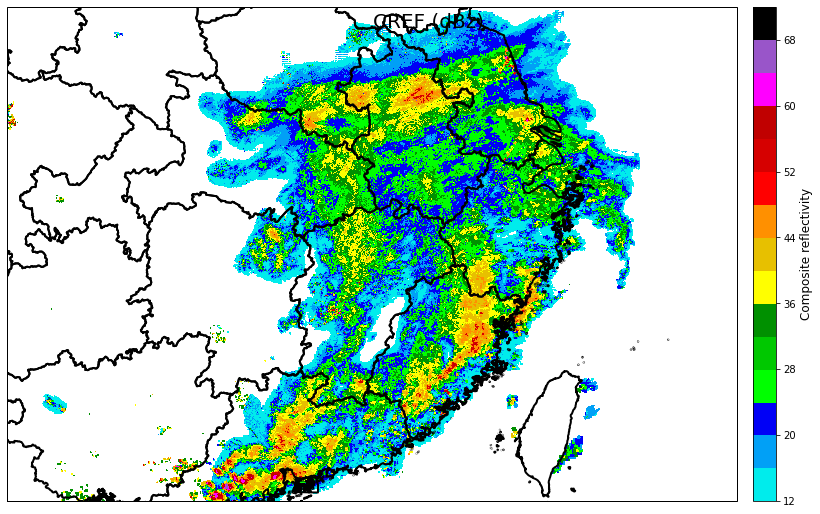

In [44]:
# set up map projection
map_center = (116, 28)
map_width = 20
datacrs = ccrs.PlateCarree()
plotcrs = ccrs.AlbersEqualArea(
    central_latitude=map_center[1], central_longitude=map_center[0],
    standard_parallels=[30., 60.])

# set up figure
fig = plt.figure(figsize=(14, 7))
gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1, .03], bottom=.01, top=.99,
                           hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=plotcrs)

# add model title
fig.suptitle('CREF (dBz)', horizontalalignment='left', fontsize=20)

# add map background
map_extent = (
    map_center[0] - map_width/2.0, map_center[0] + map_width/2.0,
    map_center[1] - map_width/3.0, map_center[1] + map_width/3.0)
ax.set_extent(map_extent, crs=datacrs)
add_china_map_2cartopy(ax, name='province', edgecolor='black', lw=2, zorder=100)

# draw composite reflectivity
x, y = np.meshgrid(cref['lon'].values, cref['lat'].values)
norm, cmap = colortables.get_with_steps('NWSReflectivity', 12, 4)
pm = ax.pcolormesh(x, y, np.squeeze(cref['data'].values), norm=norm, cmap=cmap, transform=datacrs)
cax = plt.subplot(gs[1])
cb = plt.colorbar(pm, cax=cax, orientation='vertical', extendrect='True')
cb.set_label('Composite reflectivity', size=12)

# show figure
gs.tight_layout(fig)
plt.show()

## 读取SWAN的131雷达格式数据

In [45]:
# 读取清华大学的外推QPF预报
data = get_swan_radar("RADARMOSAIC/EXTRAPOLATION/QPF/")
data

<xarray.Dataset>
Dimensions:                  (lat: 4000, level: 1, lon: 7000, time: 1)
Coordinates:
  * time                     (time) datetime64[ns] 2020-03-27T15:00:00
  * level                    (level) float32 0.0
  * lat                      (lat) float64 15.01 15.02 15.03 ... 54.99 55.0
  * lon                      (lon) float64 70.0 70.0 70.01 ... 140.0 140.0 140.0
    forecast_reference_time  datetime64[ns] 2020-03-27T15:00:00
    forecast_period          (time) float64 0.0
Data variables:
    data                     (time, level, lat, lon) float32 0.0 0.0 ... 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra Server

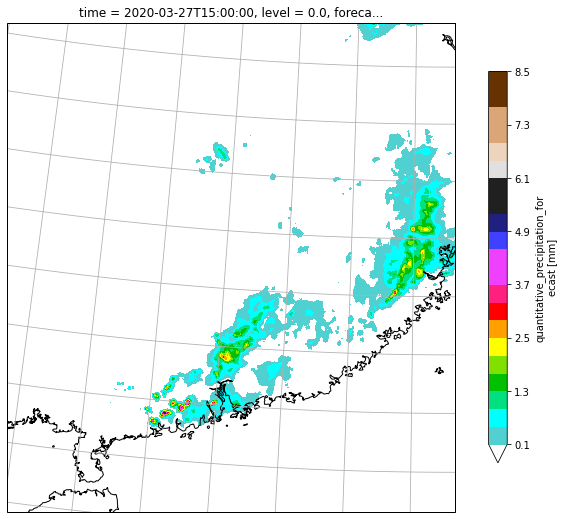

In [46]:
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=120))
norm, cmap = colortables.get_with_steps('precipitation', 0.1, 0.4)
data['data'].plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm, cmap=cmap, cbar_kwargs={'shrink': 0.8})
ax.coastlines(resolution='10m')
ax.gridlines()
ax.set_extent([108,120,20,32], crs=ccrs.PlateCarree())